In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install fasttext

    !git clone https://github.com/MartinKirkegaardDK/KDS_MI.git

    if not has_changed_dir:
        os.chdir('KDS_MI')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from drivers import (
    preprocessing,probe_confidence_intervals,
    steering, create_steering_vectors,
    steering_loss,
    distance_plots,
    create_average_activation_vectors,
    visualising_steering_vectors,
    visualising_activations,
    visualize_probe_results,
    create_bible_data,
    process_bible_data,
    visualize_bible_study
)

from pathlib import Path


## Data preprocessing

Preprocesses the multilingual data, by removing short sentences

In [ ]:
preprocessing.run()

## Analysis of residual stream activations

### PCA of activations

In [ ]:
visualising_activations.run(model_name="EleutherAI/pythia-14m")

### Classification probes

In [ ]:
probe_confidence_intervals.run(
    model_name="AI-Sweden-Models/gpt-sw3-356m",
    reg_lambdas=[0.1, 0.5, 1, 2, 5, 10]
)

In [ ]:
result_folder = Path('results/data/probe_confidence_intervals')

visualize_probe_results.run(
    probe_result_path_by_reg_lambda={
        0.1: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_0.1.json',
        0.5: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_0.5.json',
        1: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_1.json',
        2: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_2.json',
        5: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_5.json',
        10: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_10.json',
    }
)



## plots the distance plots

/Users/marki/Documents/GitHub/KDS_MI/utils/distance_plots.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  steering_vector = torch.load(str(path + file))


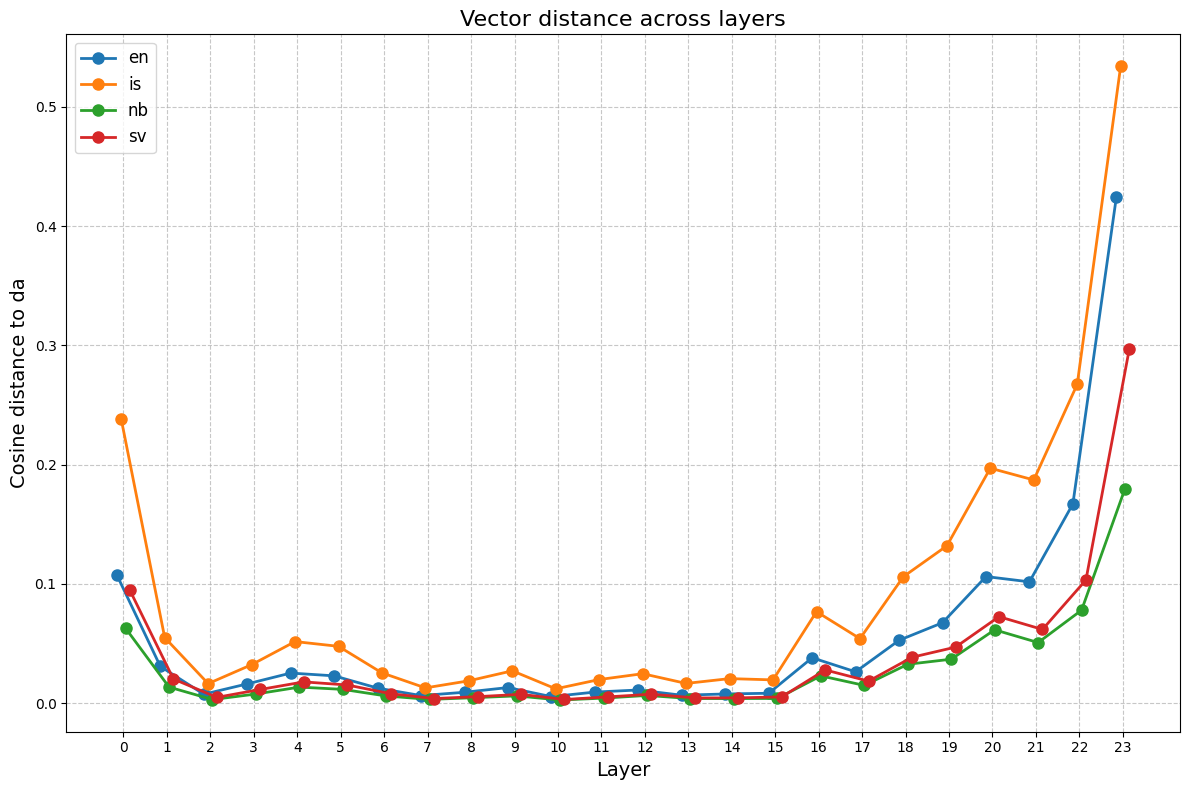

In [4]:
#AI-Sweden-Models/gpt-sw3-356m
distance_plots.run("da","average_activation_vectors/gpt_sw3_356m/","cosine")

## Create average activation vectors
these are the "base" steering vectors e.i. the average activations for different layers and languages.
This function generates them and the next block then splits them up for the analysis section

In [5]:
create_average_activation_vectors.run(["nb","is","da","en","sv"],"AI-Sweden-Models/gpt-sw3-1.3b","test_1b_model")

config.json:   0%|          | 0.00/955 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.48G [00:00<?, ?B/s]

KeyboardInterrupt: 

## Create steering vector
these are the steering vectors towards a specific language. This is different that

In [ ]:
#AI-Sweden-Models/gpt-sw3-356m
create_steering_vectors.run(
    model_name="AI-Sweden-Models/gpt-sw3-356m",
    target_language="nb",
    complement_languages=["is","da","en","sv"],
    run_name="test_test"
)

## Test steering vectors

In [8]:
layer = 5

steering_vector_path = f"steering_vectors/DA/combined_steering_vector_layer_{layer}_tensor.pt"
model_name = 'AI-Sweden-Models/gpt-sw3-356m'

steering.run(
    steering_vector_path=steering_vector_path,
    steering_lambda=5,
    affected_language="en",
    layer=layer,
    model_name=model_name,
    data_folder='data/preprocessed/train'
)

found device: cuda:0
In a pooled analysis of antibiotic stewardship studies, 55% of the studies found that the most important factor in decision-making was the quality of the antibiotic. In a survey of 180 of the largest U.S. pharmaceutical companies, 50% of the companies stated that quality of the product was the most important factor.  The United States Department of Health and Human Services (HHS) and the National Institutes of Health (NIH) 


a) Following local evidence-based antibiotic guidelines, c) after 12 weeks of therapy, d) after 6 months of therapy, e) after 3 years of therapy, and f) after 5 years of therapy. The following measures are described to determine the efficacy and safety of the anti-SARS-CoV-2 vaccine in 2020: (1) 100% response rate in the first dose, (2) 99 


Professionals in emergency departments should only start antibiotic treatment when the patient's condition worsens.  Previous: « « Kliende ögon orsak Next: Pour le corps pied » »  Copyright © Any content,

## Measure steering vector loss impact

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/955 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

found device: cuda:0


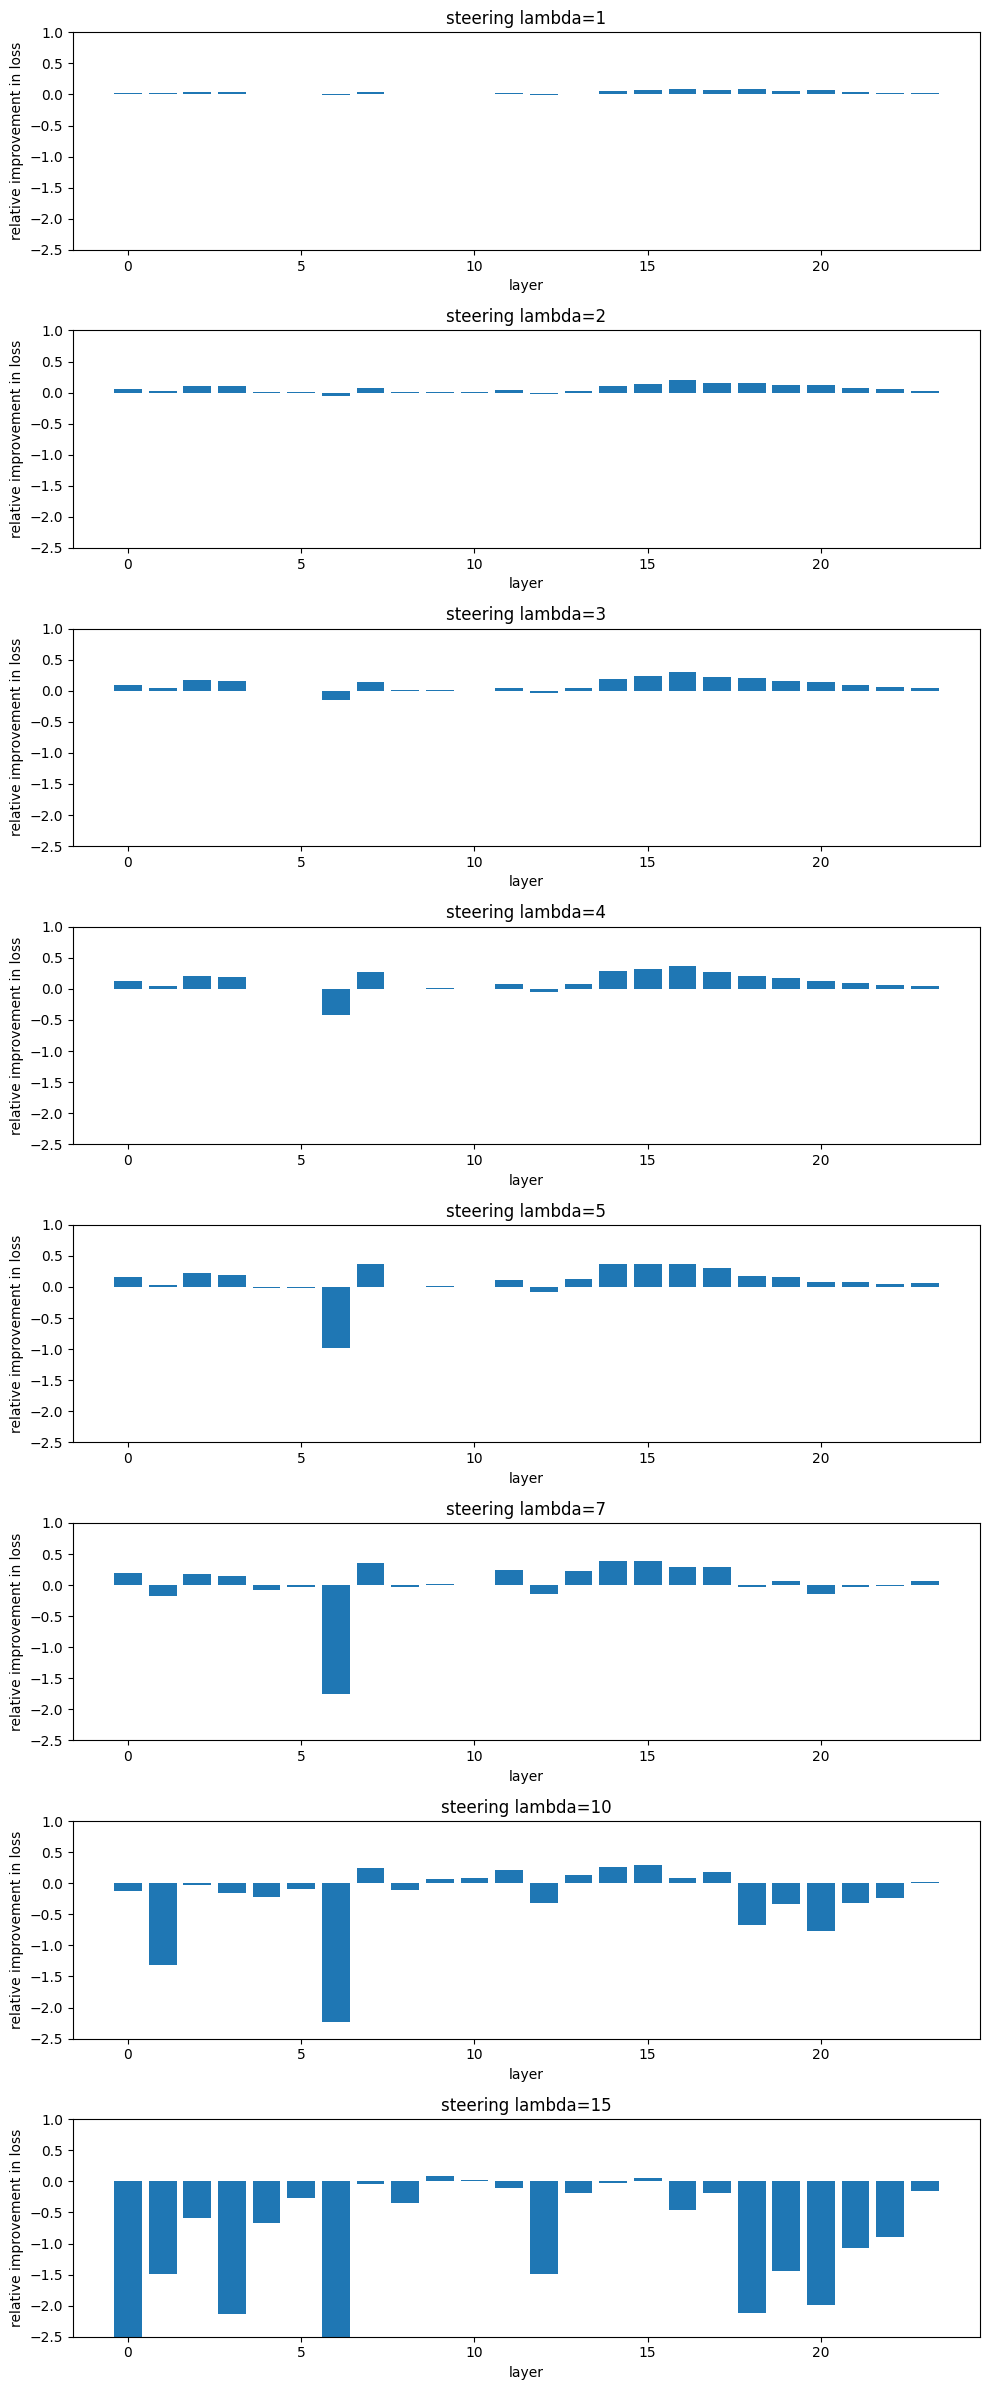

In [4]:
steering_vector_folder = 'steering_vectors/DA'

steering_loss.run(
    steering_vector_folder=steering_vector_folder,
    model_name="AI-Sweden-Models/gpt-sw3-356m"
)

## Plot steering vector PCAs

In [ ]:
steering_vector_folder = Path('steering_vectors/')

visualising_steering_vectors.run(
    steering_vector_paths_by_language={
        'en': lambda layer: steering_vector_folder / f'EN/combined_steering_vector_layer_{layer}_tensor.pt',
        'da': lambda layer: steering_vector_folder / f'DA/combined_steering_vector_layer_{layer}_tensor.pt',
        'sv': lambda layer: steering_vector_folder / f'SV/combined_steering_vector_layer_{layer}_tensor.pt',
        'nb': lambda layer: steering_vector_folder / f'NB/combined_steering_vector_layer_{layer}_tensor.pt',
        'is': lambda layer: steering_vector_folder / f'IS/combined_steering_vector_layer_{layer}_tensor.pt'
    },
    hidden_layers=24
)

## Bible study

In [ ]:
steering_vector_path = "steering_vectors/test_run_2/"
model_name = "AI-Sweden-Models/gpt-sw3-356m"
language1 = "da"
langauge2 = "en"
start_verse = 3
end_verse = 1000
lambda_search_space = [2,5,10,15]

create_bible_data.run(model_name,language1, steering_vector_path, lambda_search_space, start_verse,end_verse)


In [ ]:
path = "results/data/steering_data_bible/"
language_label = "__label__dan"
process_bible_data.run(path, language_label)

In [ ]:
visualize_bible_study.run(
    file_path='results/data/steering_data_bible/bible_data_combined.csv'
)